## Importing Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Visualization
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme()

# Library for preprocessing 
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# Hyperparameter tuning
import optuna
from optuna.samplers import TPESampler
# Suppress optuna logs for cleaner output
optuna.logging.set_verbosity(optuna.logging.WARNING)

# import library for balanse data
from imblearn.over_sampling import SMOTE

# ML library
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

# Evaluation Metrics
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                            f1_score, roc_auc_score, confusion_matrix, 
                            classification_report)


# run time
import time                            

## Data Preprocessing and Initial Checks

In [3]:
df = pd.read_csv('data/IT_customer_churn.csv')
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
# Statistical Summary
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [5]:
# Getting info for recognizing data type and missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


##### Dataset Issues

- The **TotalCharges** column contains numbers but is stored as an object (string) type.  
- All **Boolean columns** should be converted into numeric format.  
- The columns **InternetService**, **Contract**, and **PaymentMethod** need to be **encoded**.  
- After converting **TotalCharges** to numeric, there are **11 missing values**. Since this is a small number, they can be ignored.


In [6]:
# Solving probelem of a TotalCharges culomn(object to numeric)
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"] , errors='coerce')

In [7]:
# Checking missing values in dataset
df.isnull().sum()

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [8]:
# Filling missing values
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

In [9]:
# Define numerical & categorical columns
numeric_features = [feature for feature in df.columns if df[feature].dtype != 'O']
categorical_features = [feature for feature in df.columns if df[feature].dtype == 'O']

# Display counts
print(f"🔢 Numerical Features ({len(numeric_features)}):")
print(numeric_features)
print("\n🧩 Categorical Features ({len(categorical_features)}):")
print(categorical_features)

# Create a summary DataFrame for categorical columns and their unique values
cat_summary = pd.DataFrame({
    'Categorical Feature': categorical_features,
    'Unique Values': [df[col].unique() for col in categorical_features],
    'Count of Unique Values': [df[col].nunique() for col in categorical_features]
})

# Display neatly
print("\n📊 Summary of Categorical Features:\n")
display(cat_summary)

🔢 Numerical Features (4):
['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']

🧩 Categorical Features ({len(categorical_features)}):
['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']

📊 Summary of Categorical Features:



,Categorical Feature,Unique Values,Count of Unique Values
0,gender,"[Female, Male]",2
1,Partner,"[Yes, No]",2
2,Dependents,"[No, Yes]",2
3,PhoneService,"[No, Yes]",2
4,MultipleLines,"[No phone service, No, Yes]",3
5,InternetService,"[DSL, Fiber optic, No]",3
6,OnlineSecurity,"[No, Yes, No internet service]",3
7,OnlineBackup,"[Yes, No, No internet service]",3
8,DeviceProtection,"[No, Yes, No internet service]",3
9,TechSupport,"[No, Yes, No internet service]",3


## Data Visualization

In [10]:
# Create tenure groups for better analysis
df['tenure_group'] = pd.cut(df['tenure'], bins=[0, 12, 24, 48, 72], 
                             labels=['0-1 Year', '1-2 Years', '2-4 Years', '4-6 Years'])

#### Churn Distribution and Demographics

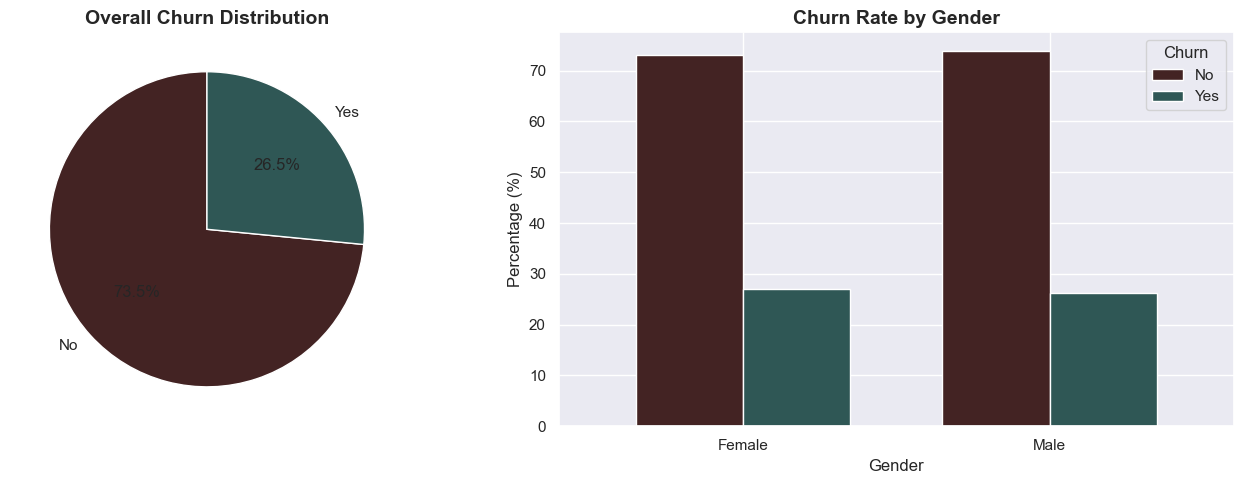

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Overall Churn Distribution
churn_counts = df['Churn'].value_counts()
colors = ['#432323', '#2F5755']
axes[0].pie(churn_counts, labels=churn_counts.index, autopct='%1.1f%%', 
            colors=colors, startangle=90)
axes[0].set_title('Overall Churn Distribution', fontsize=14, fontweight='bold')

# Churn by Gender
churn_gender = pd.crosstab(df['gender'], df['Churn'], normalize='index') * 100
churn_gender.plot(kind='bar', ax=axes[1], color=colors, width=0.7)
axes[1].set_title('Churn Rate by Gender', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Gender', fontsize=12)
axes[1].set_ylabel('Percentage (%)', fontsize=12)
axes[1].legend(title='Churn', labels=['No', 'Yes'])
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()

#### Customer Demographics Analysis

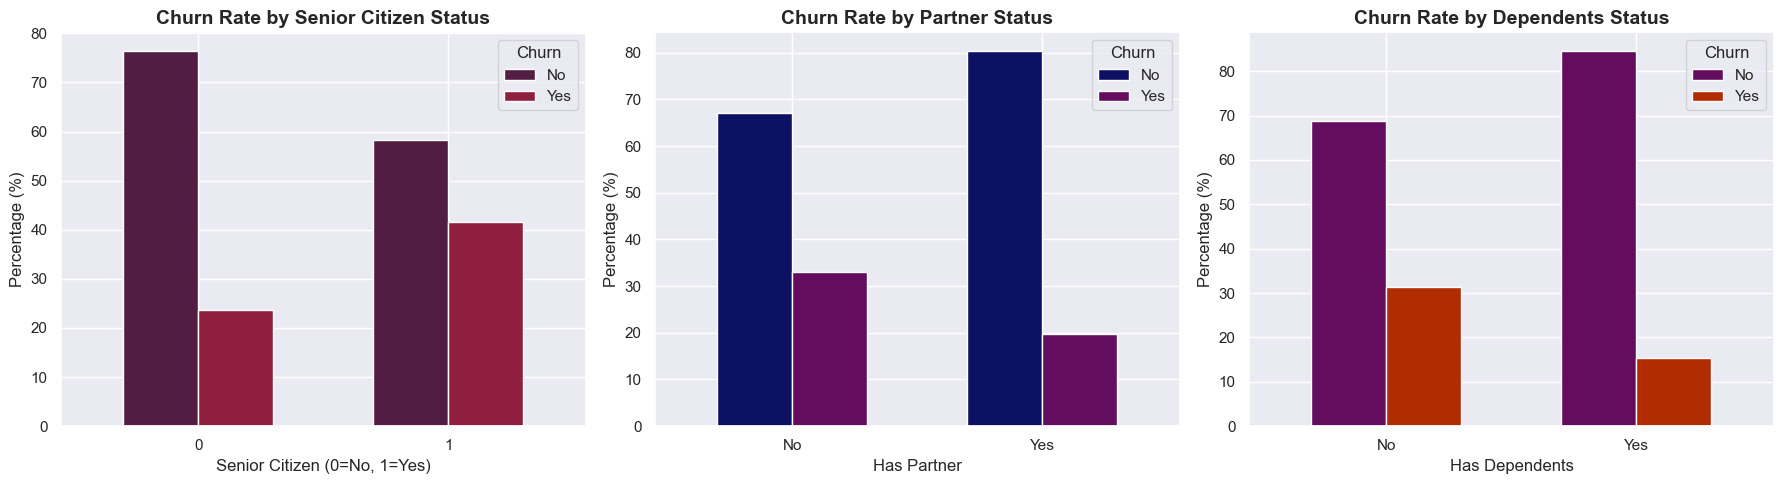

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Churn by Senior Citizen
churn_senior = pd.crosstab(df['SeniorCitizen'], df['Churn'], normalize='index') * 100
churn_senior.plot(kind='bar', ax=axes[0], color=['#511D43', '#901E3E'], width=0.6)
axes[0].set_title('Churn Rate by Senior Citizen Status', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Senior Citizen (0=No, 1=Yes)', fontsize=12)
axes[0].set_ylabel('Percentage (%)', fontsize=12)
axes[0].legend(title='Churn', labels=['No', 'Yes'])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)

# Churn by Partner
churn_partner = pd.crosstab(df['Partner'], df['Churn'], normalize='index') * 100
churn_partner.plot(kind='bar', ax=axes[1], color=['#0D1164', '#640D5F'], width=0.6)
axes[1].set_title('Churn Rate by Partner Status', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Has Partner', fontsize=12)
axes[1].set_ylabel('Percentage (%)', fontsize=12)
axes[1].legend(title='Churn', labels=['No', 'Yes'])
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)

# Churn by Dependents
churn_dep = pd.crosstab(df['Dependents'], df['Churn'], normalize='index') * 100
churn_dep.plot(kind='bar', ax=axes[2], color=['#640D5F', '#B12C00'], width=0.6)
axes[2].set_title('Churn Rate by Dependents Status', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Has Dependents', fontsize=12)
axes[2].set_ylabel('Percentage (%)', fontsize=12)
axes[2].legend(title='Churn', labels=['No', 'Yes'])
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()

#### Tenure and Contract Analysis

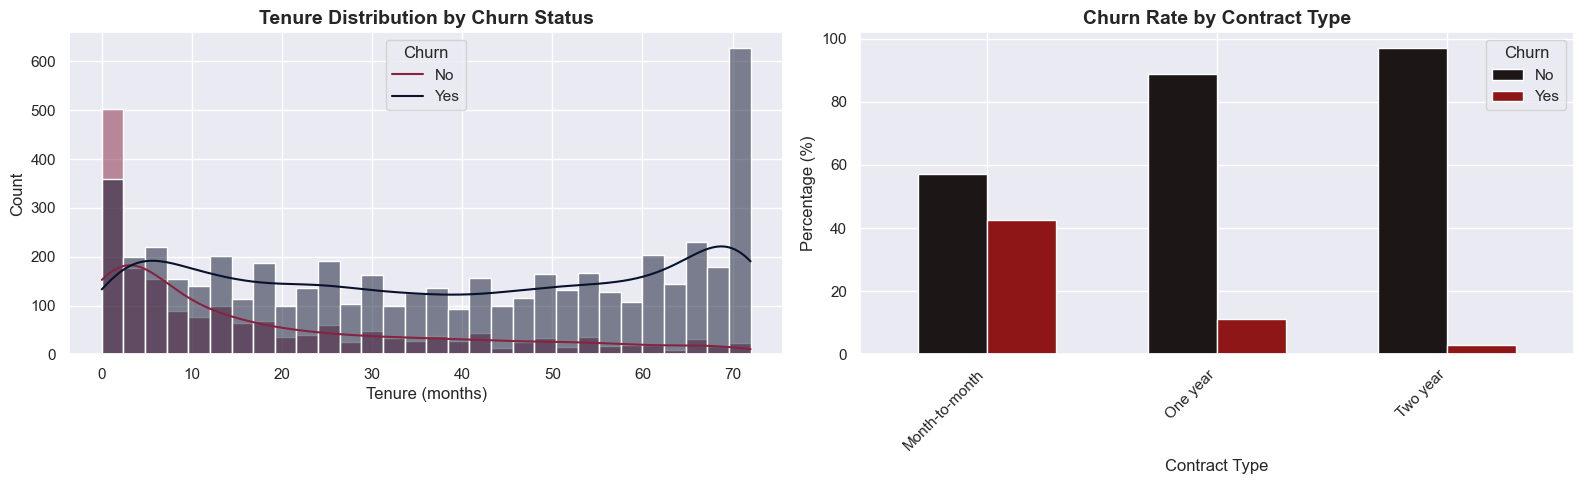

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Tenure Distribution by Churn
sns.histplot(data=df, x='tenure', hue='Churn', bins=30, 
             palette=['#09122C', '#872341'], ax=axes[0], kde=True)
axes[0].set_title('Tenure Distribution by Churn Status', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Tenure (months)', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].legend(title='Churn', labels=['No', 'Yes'])

# Churn by Contract Type
churn_contract = pd.crosstab(df['Contract'], df['Churn'], normalize='index') * 100
churn_contract.plot(kind='bar', ax=axes[1], color=['#1D1616', '#8E1616'], width=0.6)
axes[1].set_title('Churn Rate by Contract Type', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Contract Type', fontsize=12)
axes[1].set_ylabel('Percentage (%)', fontsize=12)
axes[1].legend(title='Churn', labels=['No', 'Yes'])
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

#### Payment and Billing Analysis

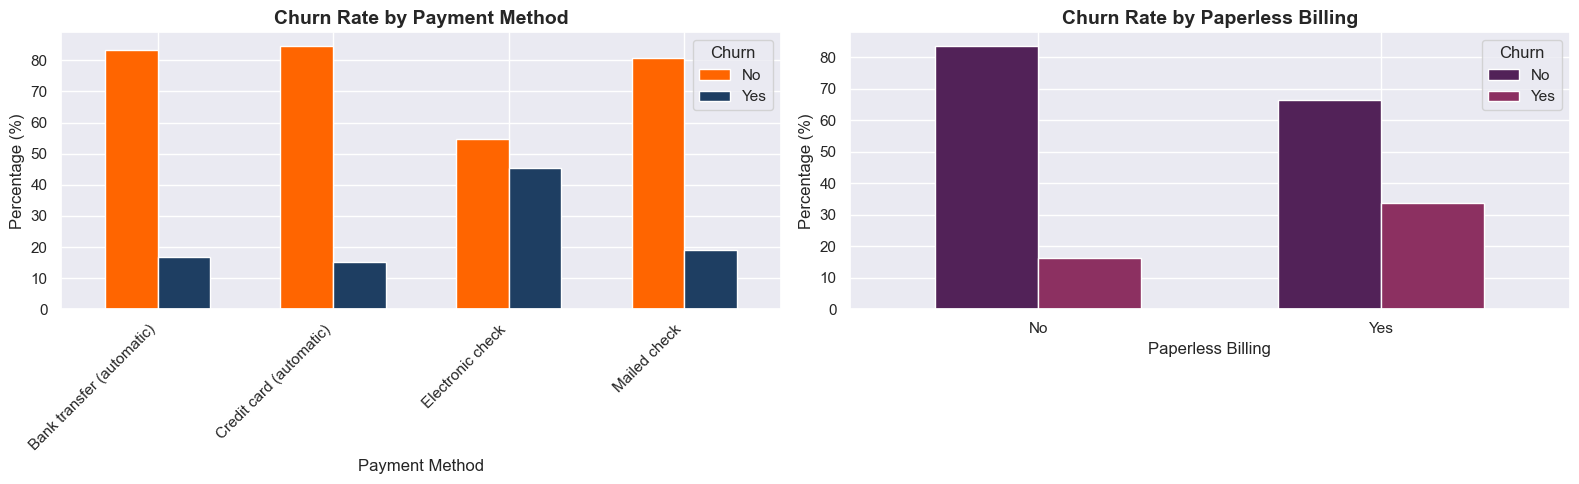

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Churn by Payment Method
churn_payment = pd.crosstab(df['PaymentMethod'], df['Churn'], normalize='index') * 100
churn_payment.plot(kind='bar', ax=axes[0], color=['#FF6500', '#1E3E62'], width=0.6)
axes[0].set_title('Churn Rate by Payment Method', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Payment Method', fontsize=12)
axes[0].set_ylabel('Percentage (%)', fontsize=12)
axes[0].legend(title='Churn', labels=['No', 'Yes'])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')

# Churn by Paperless Billing
churn_billing = pd.crosstab(df['PaperlessBilling'], df['Churn'], normalize='index') * 100
churn_billing.plot(kind='bar', ax=axes[1], color=['#522258', '#8C3061'], width=0.6)
axes[1].set_title('Churn Rate by Paperless Billing', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Paperless Billing', fontsize=12)
axes[1].set_ylabel('Percentage (%)', fontsize=12)
axes[1].legend(title='Churn', labels=['No', 'Yes'])
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()

#### Service Feature Analysis

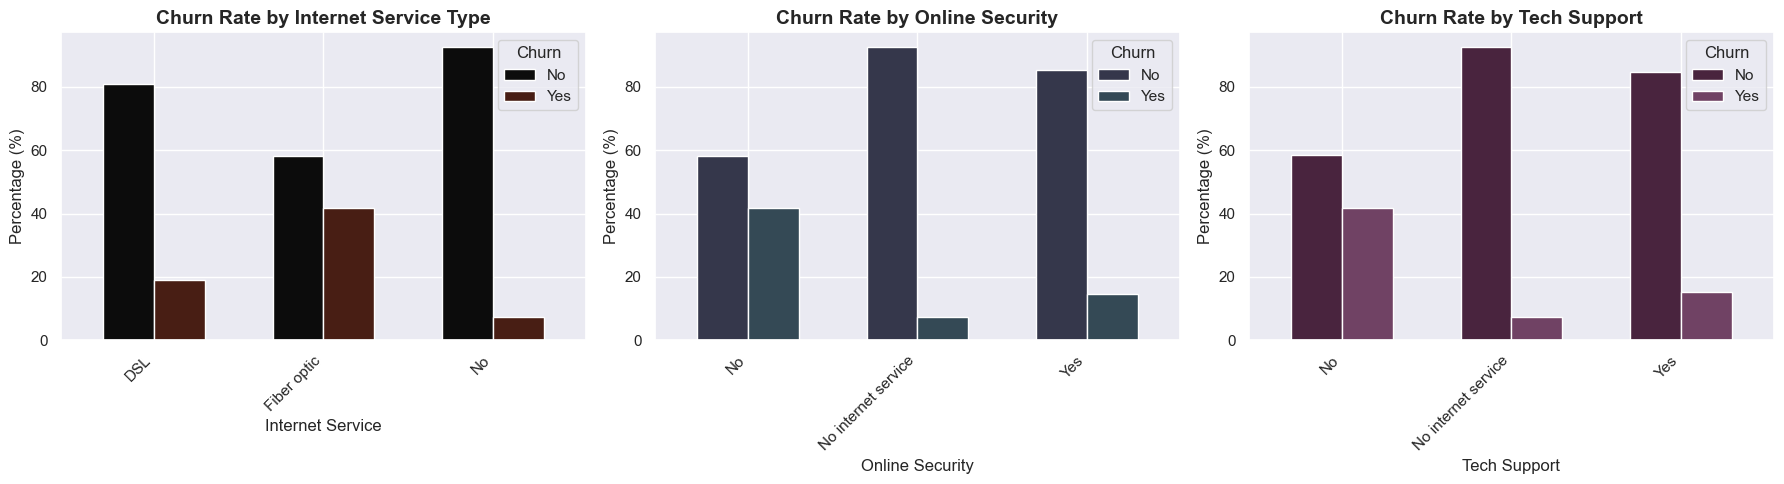

In [15]:

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Churn by Internet Service
churn_internet = pd.crosstab(df['InternetService'], df['Churn'], normalize='index') * 100
churn_internet.plot(kind='bar', ax=axes[0], color=['#0C0C0C', '#481E14'], width=0.6)
axes[0].set_title('Churn Rate by Internet Service Type', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Internet Service', fontsize=12)
axes[0].set_ylabel('Percentage (%)', fontsize=12)
axes[0].legend(title='Churn', labels=['No', 'Yes'])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')

# Churn by Online Security
churn_security = pd.crosstab(df['OnlineSecurity'], df['Churn'], normalize='index') * 100
churn_security.plot(kind='bar', ax=axes[1], color=['#35374B', '#344955'], width=0.6)
axes[1].set_title('Churn Rate by Online Security', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Online Security', fontsize=12)
axes[1].set_ylabel('Percentage (%)', fontsize=12)
axes[1].legend(title='Churn', labels=['No', 'Yes'])
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')

# Churn by Tech Support
churn_tech = pd.crosstab(df['TechSupport'], df['Churn'], normalize='index') * 100
churn_tech.plot(kind='bar', ax=axes[2], color=['#49243E', '#704264'], width=0.6)
axes[2].set_title('Churn Rate by Tech Support', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Tech Support', fontsize=12)
axes[2].set_ylabel('Percentage (%)', fontsize=12)
axes[2].legend(title='Churn', labels=['No', 'Yes'])
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

#### Charges and Financial Analysis

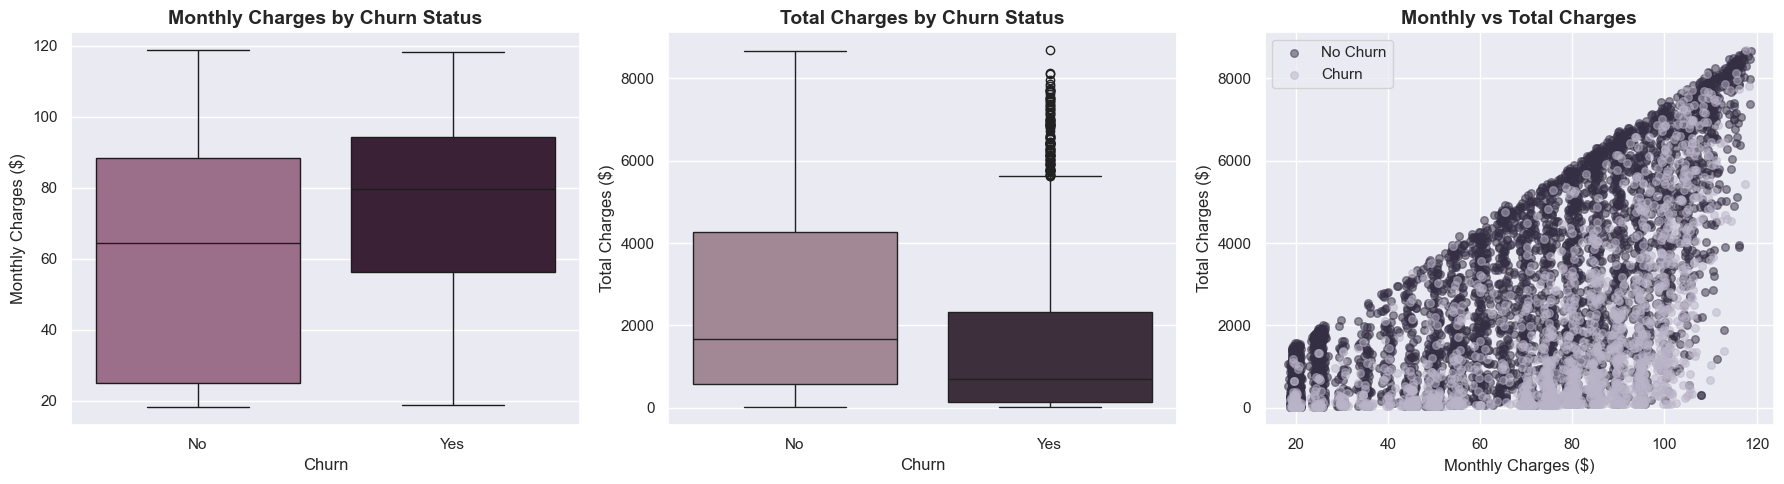

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Monthly Charges Distribution by Churn
sns.boxplot(data=df, x='Churn', y='MonthlyCharges', 
            palette=['#A2678A', '#3F1D38'], ax=axes[0])
axes[0].set_title('Monthly Charges by Churn Status', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Churn', fontsize=12)
axes[0].set_ylabel('Monthly Charges ($)', fontsize=12)

# Total Charges Distribution by Churn
sns.boxplot(data=df, x='Churn', y='TotalCharges', 
            palette=['#A78295', '#3F2E3E'], ax=axes[1])
axes[1].set_title('Total Charges by Churn Status', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Churn', fontsize=12)
axes[1].set_ylabel('Total Charges ($)', fontsize=12)

# Scatter - Monthly vs Total Charges colored by Churn
churn_no = df[df['Churn'] == 'No']
churn_yes = df[df['Churn'] == 'Yes']
axes[2].scatter(churn_no['MonthlyCharges'], churn_no['TotalCharges'], 
                alpha=0.5, c='#352F44', label='No Churn', s=30)
axes[2].scatter(churn_yes['MonthlyCharges'], churn_yes['TotalCharges'], 
                alpha=0.5, c='#B9B4C7', label='Churn', s=30)
axes[2].set_title('Monthly vs Total Charges', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Monthly Charges ($)', fontsize=12)
axes[2].set_ylabel('Total Charges ($)', fontsize=12)
axes[2].legend()

plt.tight_layout()
plt.show()

### Custom Feature Analysis

In [17]:
# Create custom features for deeper analysis

# 1. Service Count - Total number of services subscribed
service_cols = ['PhoneService', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 
                'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

df['ServiceCount'] = 0
for col in service_cols:
    if col == 'PhoneService':
        df['ServiceCount'] += (df[col] == 'Yes').astype(int)
    elif col == 'InternetService':
        df['ServiceCount'] += (df[col] != 'No').astype(int)
    else:
        df['ServiceCount'] += (df[col] == 'Yes').astype(int)

# 2. Average Monthly Rate (Total Charges / Tenure) - to identify pricing sensitivity
df['AvgMonthlyRate'] = df['TotalCharges'] / df['tenure'].replace(0, 1)

# 3. Has Premium Services (Online Security, Online Backup, Device Protection, Tech Support)
premium_services = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport']
df['PremiumServiceCount'] = sum([(df[col] == 'Yes').astype(int) for col in premium_services])
df['HasPremiumServices'] = (df['PremiumServiceCount'] > 0).map({True: 'Yes', False: 'No'})

# 4. Has Streaming Services
df['HasStreaming'] = ((df['StreamingTV'] == 'Yes') | (df['StreamingMovies'] == 'Yes')).map({True: 'Yes', False: 'No'})

# 5. Customer Value Segment based on Monthly Charges
df['ValueSegment'] = pd.cut(df['MonthlyCharges'], 
                             bins=[0, 35, 70, 120], 
                             labels=['Low Value', 'Medium Value', 'High Value'])

# 6. Loyalty Segment based on tenure
df['LoyaltySegment'] = pd.cut(df['tenure'], 
                               bins=[0, 6, 24, 48, 72], 
                               labels=['New (<6m)', 'Regular (6-24m)', 'Loyal (24-48m)', 'Champion (>48m)'])

# 7. Is High Risk Customer (Month-to-month + Electronic check)
df['HighRiskProfile'] = ((df['Contract'] == 'Month-to-month') & 
                          (df['PaymentMethod'] == 'Electronic check')).map({True: 'Yes', False: 'No'})

# 8. Family Customer (Has partner OR dependents)
df['FamilyCustomer'] = ((df['Partner'] == 'Yes') | (df['Dependents'] == 'Yes')).map({True: 'Yes', False: 'No'})

print("Custom Features Created Successfully!")
print("\nNew Feature Summary:")
print(f"1. ServiceCount: Range {df['ServiceCount'].min()} - {df['ServiceCount'].max()}")
print(f"2. AvgMonthlyRate: Mean ${df['AvgMonthlyRate'].mean():.2f}")
print(f"3. PremiumServiceCount: Range {df['PremiumServiceCount'].min()} - {df['PremiumServiceCount'].max()}")
print(f"4. HasPremiumServices: {df['HasPremiumServices'].value_counts().to_dict()}")
print(f"5. HasStreaming: {df['HasStreaming'].value_counts().to_dict()}")
print(f"6. ValueSegment: {df['ValueSegment'].value_counts().to_dict()}")
print(f"7. LoyaltySegment: {df['LoyaltySegment'].value_counts().to_dict()}")
print(f"8. HighRiskProfile: {df['HighRiskProfile'].value_counts().to_dict()}")
print(f"9. FamilyCustomer: {df['FamilyCustomer'].value_counts().to_dict()}")

Custom Features Created Successfully!

New Feature Summary:
1. ServiceCount: Range 1 - 8
2. AvgMonthlyRate: Mean $66.88
3. PremiumServiceCount: Range 0 - 4
4. HasPremiumServices: {'Yes': 4250, 'No': 2793}
5. HasStreaming: {'No': 3544, 'Yes': 3499}
6. ValueSegment: {'High Value': 3583, 'Low Value': 1735, 'Medium Value': 1725}
7. LoyaltySegment: {'Champion (>48m)': 2239, 'Regular (6-24m)': 1729, 'Loyal (24-48m)': 1594, 'New (<6m)': 1470}
8. HighRiskProfile: {'No': 5193, 'Yes': 1850}
9. FamilyCustomer: {'Yes': 3763, 'No': 3280}


#### Service Analysis

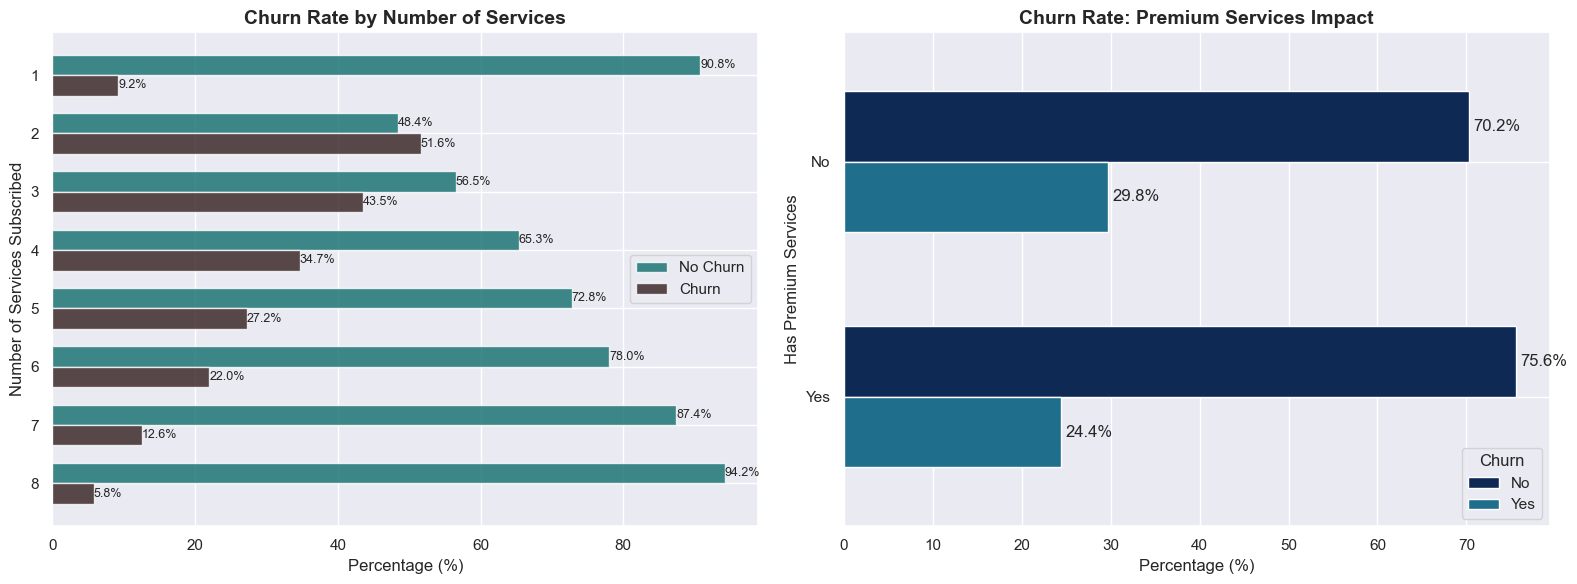

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Service Count Distribution by Churn
service_churn = df.groupby(['ServiceCount', 'Churn']).size().unstack(fill_value=0)
service_churn_pct = service_churn.div(service_churn.sum(axis=1), axis=0) * 100

x = np.arange(len(service_churn_pct.index))
width = 0.35

bars1 = axes[0].barh(x - width/2, service_churn_pct['No'], width, 
                      label='No Churn', color='#116D6E', alpha=0.8)
bars2 = axes[0].barh(x + width/2, service_churn_pct['Yes'], width, 
                      label='Churn', color='#321E1E', alpha=0.8)

axes[0].set_xlabel('Percentage (%)', fontsize=12)
axes[0].set_ylabel('Number of Services Subscribed', fontsize=12)
axes[0].set_title('Churn Rate by Number of Services', fontsize=14, fontweight='bold')
axes[0].set_yticks(x)
axes[0].set_yticklabels(service_churn_pct.index)
axes[0].legend()
axes[0].invert_yaxis()

# Add percentage labels
for bars in [bars1, bars2]:
    for bar in bars:
        width_val = bar.get_width()
        if width_val > 0:
            axes[0].text(width_val, bar.get_y() + bar.get_height()/2, 
                        f'{width_val:.1f}%', ha='left', va='center', fontsize=9)

# Churn by Premium Services
churn_premium = pd.crosstab(df['HasPremiumServices'], df['Churn'], normalize='index') * 100
churn_premium.plot(kind='barh', ax=axes[1], color=['#0E2954', '#1F6E8C'], width=0.6)
axes[1].set_title('Churn Rate: Premium Services Impact', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Percentage (%)', fontsize=12)
axes[1].set_ylabel('Has Premium Services', fontsize=12)
axes[1].legend(title='Churn', labels=['No', 'Yes'])
axes[1].invert_yaxis()

# Add percentage labels
for container in axes[1].containers:
    axes[1].bar_label(container, fmt='%.1f%%', padding=3)

plt.tight_layout()
plt.show()

#### Customer Segmentation Analysis

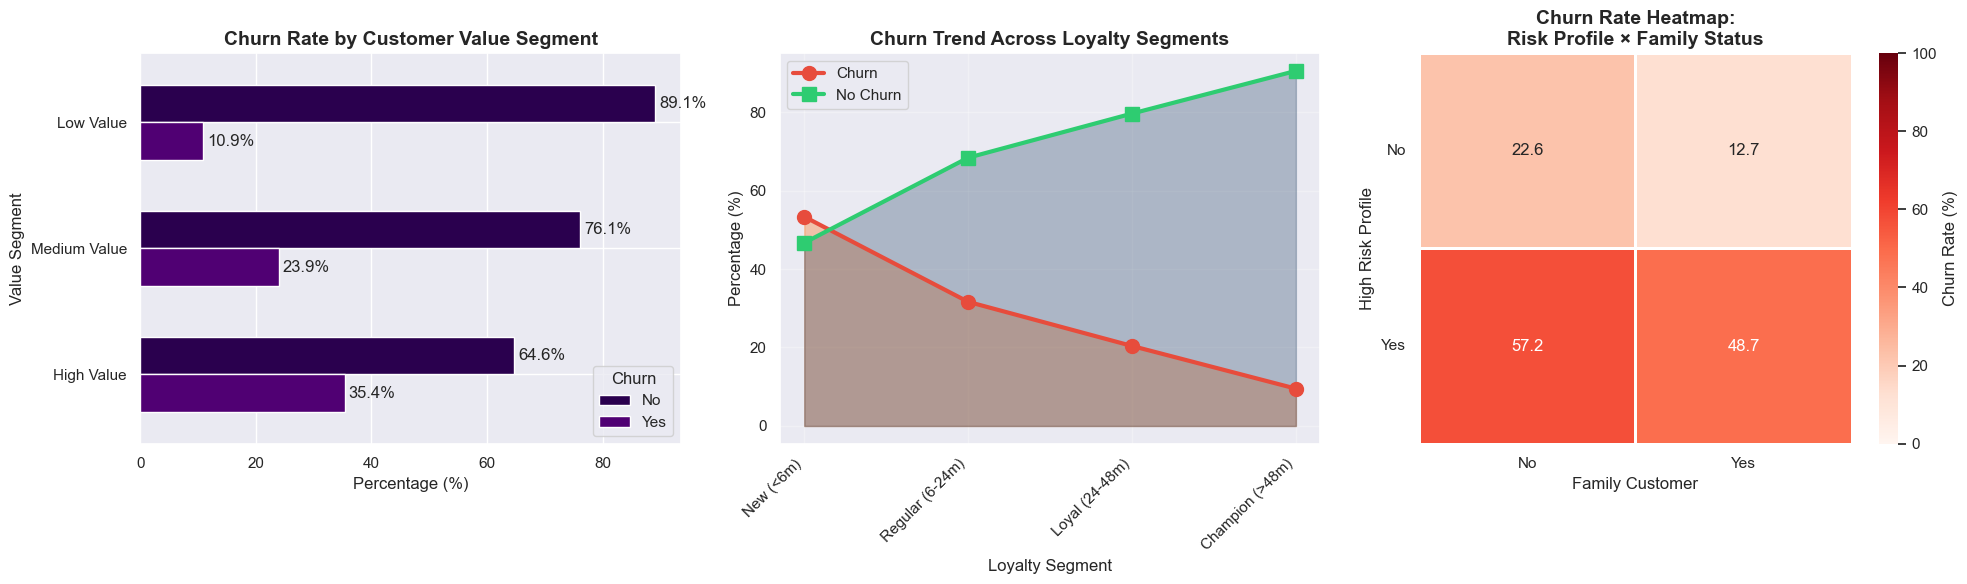

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Value Segment Analysis
value_churn = pd.crosstab(df['ValueSegment'], df['Churn'], normalize='index') * 100
value_churn.plot(kind='barh', ax=axes[0], color=['#2A004E', '#500073'], width=0.6)
axes[0].set_title('Churn Rate by Customer Value Segment', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Percentage (%)', fontsize=12)
axes[0].set_ylabel('Value Segment', fontsize=12)
axes[0].legend(title='Churn', labels=['No', 'Yes'])
axes[0].invert_yaxis()

for container in axes[0].containers:
    axes[0].bar_label(container, fmt='%.1f%%', padding=3)

# Loyalty Segment Analysis (Stacked Area Chart Alternative - using line plot)
loyalty_data = df.groupby(['LoyaltySegment', 'Churn']).size().unstack(fill_value=0)
loyalty_pct = loyalty_data.div(loyalty_data.sum(axis=1), axis=0) * 100

loyalty_segments_order = ['New (<6m)', 'Regular (6-24m)', 'Loyal (24-48m)', 'Champion (>48m)']
loyalty_pct = loyalty_pct.reindex(loyalty_segments_order)

x_pos = np.arange(len(loyalty_pct.index))
axes[1].plot(x_pos, loyalty_pct['Yes'], marker='o', linewidth=3, 
             markersize=10, color='#e74c3c', label='Churn')
axes[1].plot(x_pos, loyalty_pct['No'], marker='s', linewidth=3, 
             markersize=10, color='#2ecc71', label='No Churn')
axes[1].fill_between(x_pos, loyalty_pct['Yes'], alpha=0.3, color='#FF6500')
axes[1].fill_between(x_pos, loyalty_pct['No'], alpha=0.3, color='#1E3E62')

axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(loyalty_pct.index, rotation=45, ha='right')
axes[1].set_xlabel('Loyalty Segment', fontsize=12)
axes[1].set_ylabel('Percentage (%)', fontsize=12)
axes[1].set_title('Churn Trend Across Loyalty Segments', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# High Risk Profile vs Family Customer (Heatmap style visualization)
risk_family_churn = df.groupby(['HighRiskProfile', 'FamilyCustomer', 'Churn']).size().unstack(fill_value=0)
risk_family_pct = risk_family_churn.div(risk_family_churn.sum(axis=1), axis=0) * 100

# Pivot for heatmap
heatmap_data = risk_family_pct['Yes'].unstack(level=1)

sns.heatmap(heatmap_data, annot=True, fmt='.1f', cmap='Reds', 
            cbar_kws={'label': 'Churn Rate (%)'}, ax=axes[2], 
            vmin=0, vmax=100, linewidths=2, linecolor='white')
axes[2].set_title('Churn Rate Heatmap:\nRisk Profile × Family Status', 
                  fontsize=14, fontweight='bold')
axes[2].set_xlabel('Family Customer', fontsize=12)
axes[2].set_ylabel('High Risk Profile', fontsize=12)
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=0)
axes[2].set_yticklabels(axes[2].get_yticklabels(), rotation=0)

plt.tight_layout()
plt.show()

#### Streaming and Premium Services Deep Down

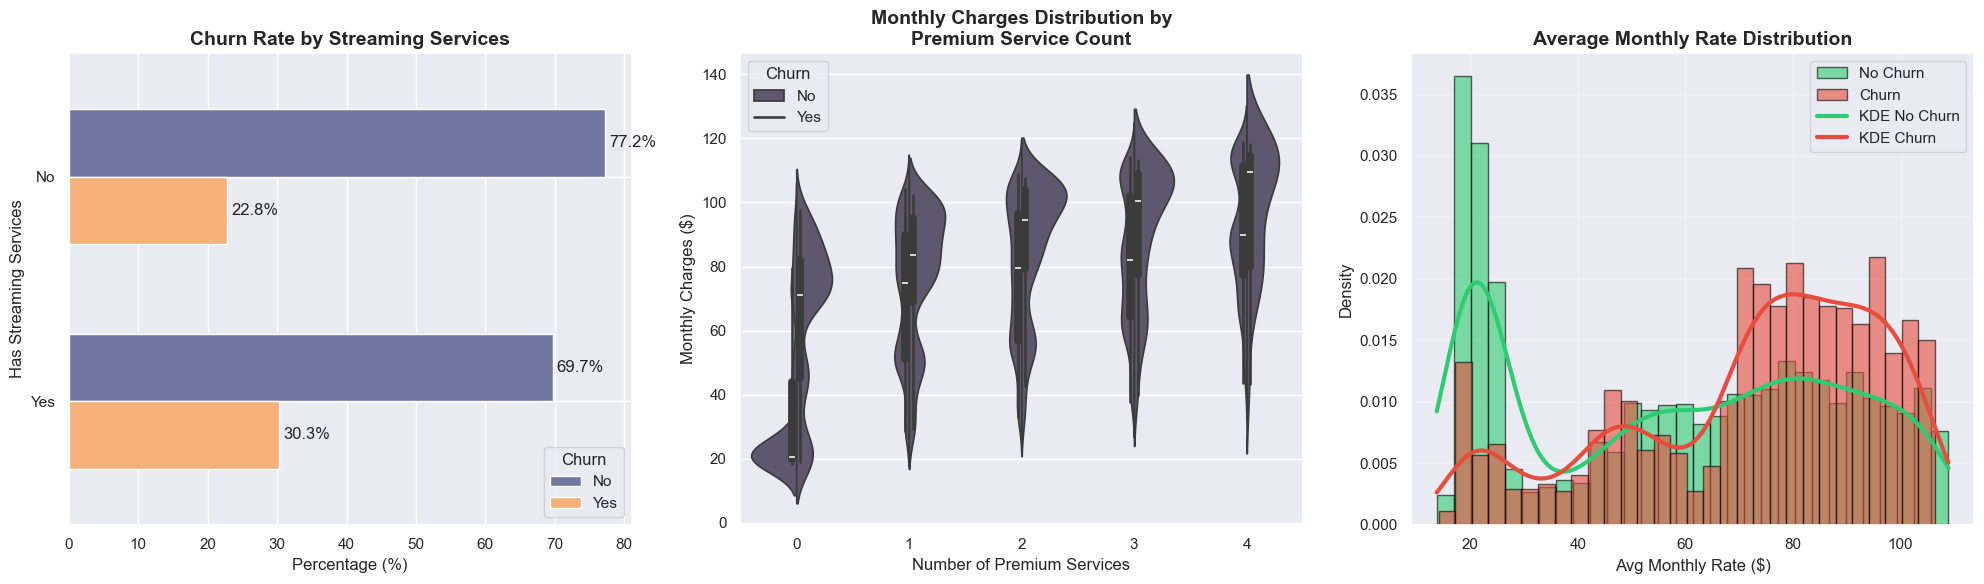

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Streaming Services Impact
streaming_churn = pd.crosstab(df['HasStreaming'], df['Churn'], normalize='index') * 100
streaming_churn.plot(kind='barh', ax=axes[0], color=['#7077A1', '#F6B17A'], width=0.6)
axes[0].set_title('Churn Rate by Streaming Services', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Percentage (%)', fontsize=12)
axes[0].set_ylabel('Has Streaming Services', fontsize=12)
axes[0].legend(title='Churn', labels=['No', 'Yes'])
axes[0].invert_yaxis()

for container in axes[0].containers:
    axes[0].bar_label(container, fmt='%.1f%%', padding=3)

# Premium Service Count Distribution (Violin Plot)
df_temp = df.copy()
df_temp['PremiumServiceCount'] = df_temp['PremiumServiceCount'].astype(str)
order = ['0', '1', '2', '3', '4']
existing_vals = [x for x in order if x in df_temp['PremiumServiceCount'].unique()]

sns.violinplot(data=df_temp, x='PremiumServiceCount', y='MonthlyCharges', 
               hue='Churn', split=True, palette=['#5C5470', '#5C5470'], 
               ax=axes[1], order=existing_vals)
axes[1].set_title('Monthly Charges Distribution by\nPremium Service Count', 
                  fontsize=14, fontweight='bold')
axes[1].set_xlabel('Number of Premium Services', fontsize=12)
axes[1].set_ylabel('Monthly Charges ($)', fontsize=12)
axes[1].legend(title='Churn', labels=['No', 'Yes'])

# Average Monthly Rate by Churn (KDE Plot)
churn_yes_rate = df[df['Churn'] == 'Yes']['AvgMonthlyRate'].dropna()
churn_no_rate = df[df['Churn'] == 'No']['AvgMonthlyRate'].dropna()

# Filter outliers for better visualization
churn_yes_rate = churn_yes_rate[churn_yes_rate < churn_yes_rate.quantile(0.95)]
churn_no_rate = churn_no_rate[churn_no_rate < churn_no_rate.quantile(0.95)]

axes[2].hist(churn_no_rate, bins=30, alpha=0.6, color='#2ecc71', 
             label='No Churn', density=True, edgecolor='black')
axes[2].hist(churn_yes_rate, bins=30, alpha=0.6, color='#e74c3c', 
             label='Churn', density=True, edgecolor='black')

# Add KDE lines
from scipy import stats
kde_no = stats.gaussian_kde(churn_no_rate)
kde_yes = stats.gaussian_kde(churn_yes_rate)
x_range = np.linspace(min(churn_no_rate.min(), churn_yes_rate.min()), 
                      max(churn_no_rate.max(), churn_yes_rate.max()), 200)
axes[2].plot(x_range, kde_no(x_range), color='#2ecc71', linewidth=3, label='KDE No Churn')
axes[2].plot(x_range, kde_yes(x_range), color='#e74c3c', linewidth=3, label='KDE Churn')

axes[2].set_title('Average Monthly Rate Distribution', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Avg Monthly Rate ($)', fontsize=12)
axes[2].set_ylabel('Density', fontsize=12)
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### Combined Risk Analysis

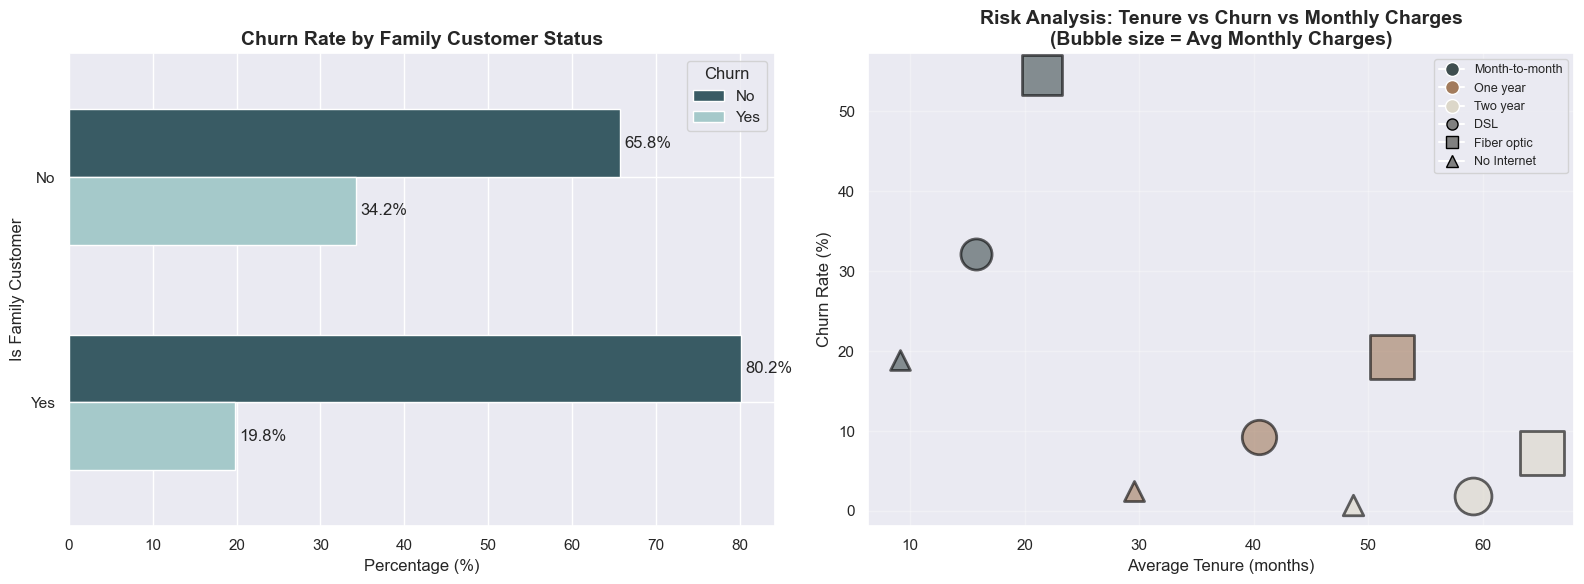

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Family Customer Impact on Churn
family_churn = pd.crosstab(df['FamilyCustomer'], df['Churn'], normalize='index') * 100
family_churn.plot(kind='barh', ax=axes[0], color=['#395B64', '#A5C9CA'], width=0.6)
axes[0].set_title('Churn Rate by Family Customer Status', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Percentage (%)', fontsize=12)
axes[0].set_ylabel('Is Family Customer', fontsize=12)
axes[0].legend(title='Churn', labels=['No', 'Yes'])
axes[0].invert_yaxis()

for container in axes[0].containers:
    axes[0].bar_label(container, fmt='%.1f%%', padding=3)

# Multi-dimensional Risk Analysis (Bubble Chart)
# Aggregate data for bubble chart
bubble_data = df.groupby(['Contract', 'InternetService']).agg({
    'Churn': lambda x: (x == 'Yes').sum() / len(x) * 100,
    'MonthlyCharges': 'mean',
    'tenure': 'mean'
}).reset_index()
bubble_data.columns = ['Contract', 'InternetService', 'ChurnRate', 'AvgMonthlyCharges', 'AvgTenure']

# Create bubble chart
contracts = bubble_data['Contract'].unique()
colors_map = {'Month-to-month': '#3F4E4F', 'One year': '#A27B5C', 'Two year': '#DCD7C9'}
markers_map = {'DSL': 'o', 'Fiber optic': 's', 'No': '^'}

for contract in contracts:
    contract_data = bubble_data[bubble_data['Contract'] == contract]
    for _, row in contract_data.iterrows():
        axes[1].scatter(row['AvgTenure'], row['ChurnRate'], 
                       s=row['AvgMonthlyCharges']*10,  # Size based on charges
                       c=colors_map.get(contract, '#95a5a6'),
                       marker=markers_map.get(row['InternetService'], 'o'),
                       alpha=0.6, edgecolors='black', linewidth=2,
                       label=f"{contract} - {row['InternetService']}")

axes[1].set_xlabel('Average Tenure (months)', fontsize=12)
axes[1].set_ylabel('Churn Rate (%)', fontsize=12)
axes[1].set_title('Risk Analysis: Tenure vs Churn vs Monthly Charges\n(Bubble size = Avg Monthly Charges)', 
                  fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Create custom legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#3F4E4F', 
           markersize=10, label='Month-to-month'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#A27B5C', 
           markersize=10, label='One year'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#DCD7C9', 
           markersize=10, label='Two year'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', 
           markersize=8, label='DSL', markeredgecolor='black'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor='gray', 
           markersize=8, label='Fiber optic', markeredgecolor='black'),
    Line2D([0], [0], marker='^', color='w', markerfacecolor='gray', 
           markersize=8, label='No Internet', markeredgecolor='black')
]
axes[1].legend(handles=legend_elements, loc='best', fontsize=9)

plt.tight_layout()
plt.show()

#### Correlation Heatmap and SUmamry Statistics

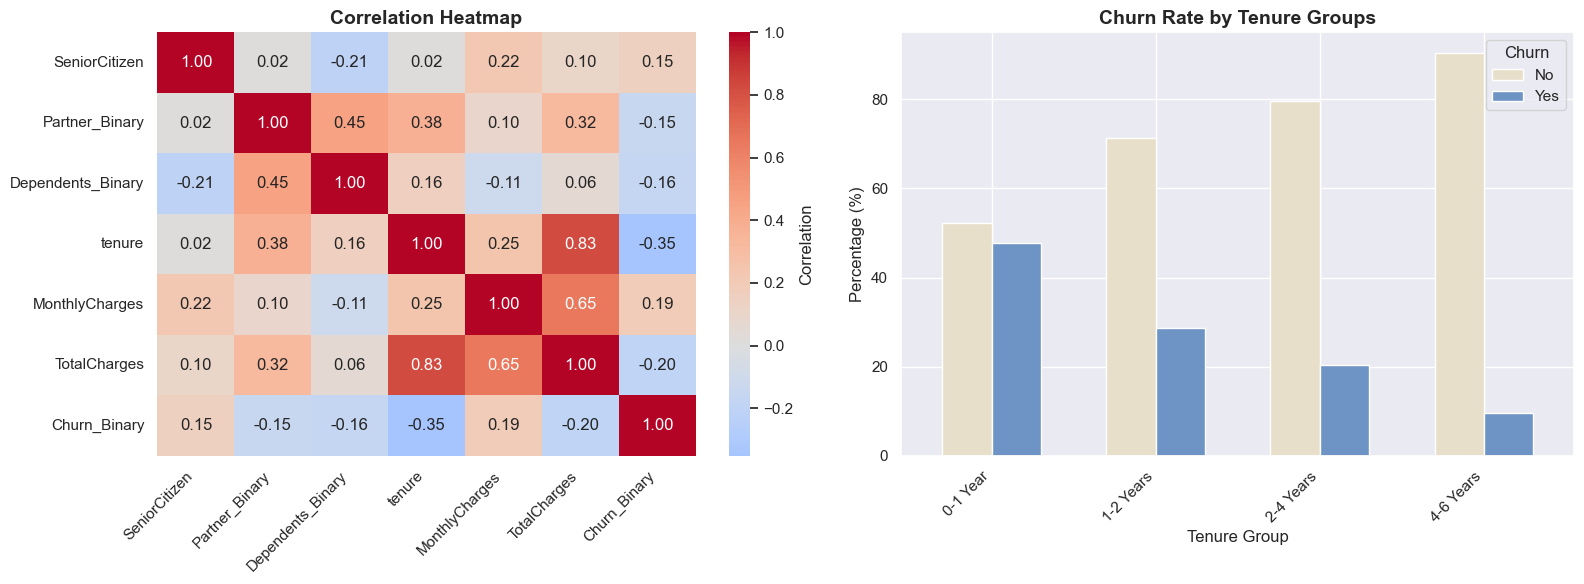

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Prepare numeric data for correlation
df_numeric = df.copy()
df_numeric['Churn_Binary'] = (df_numeric['Churn'] == 'Yes').astype(int)
df_numeric['Gender_Binary'] = (df_numeric['gender'] == 'Male').astype(int)
df_numeric['Partner_Binary'] = (df_numeric['Partner'] == 'Yes').astype(int)
df_numeric['Dependents_Binary'] = (df_numeric['Dependents'] == 'Yes').astype(int)

# Select numeric columns for correlation
numeric_cols = ['SeniorCitizen', 'Partner_Binary', 'Dependents_Binary', 
                'tenure', 'MonthlyCharges', 'TotalCharges', 'Churn_Binary']
corr_matrix = df_numeric[numeric_cols].corr()

# Correlation heatmap
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, ax=axes[0], cbar_kws={'label': 'Correlation'})
axes[0].set_title('Correlation Heatmap', fontsize=14, fontweight='bold')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')

# Churn rate by tenure groups
churn_tenure_group = pd.crosstab(df['tenure_group'], df['Churn'], normalize='index') * 100
churn_tenure_group.plot(kind='bar', ax=axes[1], color=['#E8DFCA', '#6D94C5'], width=0.6)
axes[1].set_title('Churn Rate by Tenure Groups', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Tenure Group', fontsize=12)
axes[1].set_ylabel('Percentage (%)', fontsize=12)
axes[1].legend(title='Churn', labels=['No', 'Yes'])
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

#### Key Insights

In [23]:
# Print key insights
print("="*70)
print("KEY INSIGHTS FROM EDA")
print("="*70)

# Overall churn rate
churn_rate = (df['Churn'] == 'Yes').sum() / len(df) * 100
print(f"\n1. Overall Churn Rate: {churn_rate:.2f}%")

# Churn by contract type
print("\n2. Churn Rate by Contract Type:")
contract_churn = df.groupby('Contract')['Churn'].apply(lambda x: (x == 'Yes').sum() / len(x) * 100)
for contract, rate in contract_churn.items():
    print(f"   - {contract}: {rate:.2f}%")

# Average tenure by churn
print("\n3. Average Tenure:")
print(f"   - Churned Customers: {df[df['Churn'] == 'Yes']['tenure'].mean():.2f} months")
print(f"   - Retained Customers: {df[df['Churn'] == 'No']['tenure'].mean():.2f} months")

# Average charges by churn
print("\n4. Average Monthly Charges:")
print(f"   - Churned Customers: ${df[df['Churn'] == 'Yes']['MonthlyCharges'].mean():.2f}")
print(f"   - Retained Customers: ${df[df['Churn'] == 'No']['MonthlyCharges'].mean():.2f}")

# Churn by internet service
print("\n5. Churn Rate by Internet Service:")
internet_churn = df.groupby('InternetService')['Churn'].apply(lambda x: (x == 'Yes').sum() / len(x) * 100)
for service, rate in internet_churn.items():
    print(f"   - {service}: {rate:.2f}%")

# Senior citizen impact
senior_churn = df.groupby('SeniorCitizen')['Churn'].apply(lambda x: (x == 'Yes').sum() / len(x) * 100)
print(f"\n6. Senior Citizen Churn:")
print(f"   - Non-Senior Citizens: {senior_churn[0]:.2f}%")
print(f"   - Senior Citizens: {senior_churn[1]:.2f}%")

# Custom features insights
print("\n7. Service Count Impact:")
service_churn = df.groupby('ServiceCount')['Churn'].apply(lambda x: (x == 'Yes').sum() / len(x) * 100)
print(f"   - Avg Services (Churned): {df[df['Churn'] == 'Yes']['ServiceCount'].mean():.2f}")
print(f"   - Avg Services (Retained): {df[df['Churn'] == 'No']['ServiceCount'].mean():.2f}")

print("\n8. Value Segment Churn:")
value_churn = df.groupby('ValueSegment')['Churn'].apply(lambda x: (x == 'Yes').sum() / len(x) * 100)
for segment, rate in value_churn.items():
    print(f"   - {segment}: {rate:.2f}%")

print("\n9. High Risk Profile Impact:")
risk_churn = df.groupby('HighRiskProfile')['Churn'].apply(lambda x: (x == 'Yes').sum() / len(x) * 100)
for risk, rate in risk_churn.items():
    print(f"   - High Risk = {risk}: {rate:.2f}%")

print("\n10. Family Customer Impact:")
family_churn = df.groupby('FamilyCustomer')['Churn'].apply(lambda x: (x == 'Yes').sum() / len(x) * 100)
for family, rate in family_churn.items():
    print(f"   - Family Customer = {family}: {rate:.2f}%")

print("\n" + "="*70)

KEY INSIGHTS FROM EDA

1. Overall Churn Rate: 26.54%

2. Churn Rate by Contract Type:
   - Month-to-month: 42.71%
   - One year: 11.27%
   - Two year: 2.83%

3. Average Tenure:
   - Churned Customers: 17.98 months
   - Retained Customers: 37.57 months

4. Average Monthly Charges:
   - Churned Customers: $74.44
   - Retained Customers: $61.27

5. Churn Rate by Internet Service:
   - DSL: 18.96%
   - Fiber optic: 41.89%
   - No: 7.40%

6. Senior Citizen Churn:
   - Non-Senior Citizens: 23.61%
   - Senior Citizens: 41.68%

7. Service Count Impact:
   - Avg Services (Churned): 3.62
   - Avg Services (Retained): 3.76

8. Value Segment Churn:
   - Low Value: 10.89%
   - Medium Value: 23.94%
   - High Value: 35.36%

9. High Risk Profile Impact:
   - High Risk = No: 16.85%
   - High Risk = Yes: 53.73%

10. Family Customer Impact:
   - Family Customer = No: 34.24%
   - Family Customer = Yes: 19.82%



## Feature Engineering

In [24]:
# Create a copy for modeling
df_model = df.copy()

# Drop custom features created only for EDA
cols_to_drop = ['tenure_group', 'LoyaltySegment']
df_model = df_model.drop(columns=cols_to_drop, errors='ignore')

print("Starting Feature Engineering for Modeling...")
print("="*70)

# 1. Handle categorical variables with Label Encoding
label_encoders = {}
categorical_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 
                   'MultipleLines', 'InternetService', 'OnlineSecurity',
                   'OnlineBackup', 'DeviceProtection', 'TechSupport',
                   'StreamingTV', 'StreamingMovies', 'Contract',
                   'PaperlessBilling', 'PaymentMethod', 'HasPremiumServices',
                   'HasStreaming', 'HighRiskProfile', 'FamilyCustomer', 'ValueSegment']

for col in categorical_cols:
    if col in df_model.columns:
        le = LabelEncoder()
        df_model[col] = le.fit_transform(df_model[col].astype(str))
        label_encoders[col] = le

# 2. Encode target variable
df_model['Churn'] = (df_model['Churn'] == 'Yes').astype(int)

print(f"\n✓ Encoded {len(categorical_cols)} categorical features")
print(f"✓ Target variable 'Churn' encoded (0=No, 1=Yes)")

# 3. Feature Engineering - Create interaction features
df_model['Tenure_MonthlyCharges'] = df_model['tenure'] * df_model['MonthlyCharges']
df_model['Tenure_ServiceCount'] = df_model['tenure'] * df_model['ServiceCount']
df_model['MonthlyCharges_ServiceCount'] = df_model['MonthlyCharges'] * df_model['ServiceCount']

print(f"✓ Created 3 interaction features")

# 4. Display final feature set
print("\n" + "="*70)
print("Final Feature Set:")
print(f"Total Features: {df_model.shape[1] - 1}")
print(f"Target Variable: Churn")
print("\nDataset Shape:", df_model.shape)
print("\nFirst few rows of processed data:")
print(df_model.head())

print("\n" + "="*70)
print("Class Distribution:")
print(df_model['Churn'].value_counts())
print(f"\nChurn Rate: {df_model['Churn'].mean()*100:.2f}%")

Starting Feature Engineering for Modeling...

✓ Encoded 20 categorical features
✓ Target variable 'Churn' encoded (0=No, 1=Yes)
✓ Created 3 interaction features

Final Feature Set:
Total Features: 30
Target Variable: Churn

Dataset Shape: (7043, 31)

First few rows of processed data:
   gender  SeniorCitizen  Partner  Dependents  tenure  PhoneService  \
0       0              0        1           0       1             0   
1       1              0        0           0      34             1   
2       1              0        0           0       2             1   
3       1              0        0           0      45             0   
4       0              0        0           0       2             1   

   MultipleLines  InternetService  OnlineSecurity  OnlineBackup  ...  \
0              1                0               0             2  ...   
1              0                0               2             0  ...   
2              0                0               2             2  ...   


## Handling Class Imbalance and Train-Test Split

In [25]:
# Separate features and target
X = df_model.drop('Churn', axis=1)
y = df_model['Churn']

# Balansing dataset
smote = SMOTE(sampling_strategy='minority')
X_smote, y_smote = smote.fit_resample(X, y)

In [26]:
# Split the data (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X_smote, y_smote, test_size=0.2, random_state=42, stratify=y_smote
)

print("Train-Test Split Completed!")
print("="*70)
print(f"Training Set Size: {X_train.shape[0]} samples")
print(f"Test Set Size: {X_test.shape[0]} samples")
print(f"\nTraining Set Shape: {X_train.shape}")
print(f"Test Set Shape: {X_test.shape}")

# Check class distribution
print("\n" + "="*70)
print("Class Distribution in Training Set:")
print(y_train.value_counts())
print(f"Churn Rate: {y_train.mean()*100:.2f}%")

print("\nClass Distribution in Test Set:")
print(y_test.value_counts())
print(f"Churn Rate: {y_test.mean()*100:.2f}%")

# Feature Scaling using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for better readability
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("\n" + "="*70)
print("Feature Scaling Completed!")
print("✓ StandardScaler applied to all features")
print(f"✓ Scaled Training Set Shape: {X_train_scaled.shape}")
print(f"✓ Scaled Test Set Shape: {X_test_scaled.shape}")

print("\nScaled Features Sample (first 5 rows, first 5 columns):")
print(X_train_scaled.iloc[:5, :5])

Train-Test Split Completed!
Training Set Size: 8278 samples
Test Set Size: 2070 samples

Training Set Shape: (8278, 30)
Test Set Shape: (2070, 30)

Class Distribution in Training Set:
Churn
1    4139
0    4139
Name: count, dtype: int64
Churn Rate: 50.00%

Class Distribution in Test Set:
Churn
0    1035
1    1035
Name: count, dtype: int64
Churn Rate: 50.00%

Feature Scaling Completed!
✓ StandardScaler applied to all features
✓ Scaled Training Set Shape: (8278, 30)
✓ Scaled Test Set Shape: (2070, 30)

Scaled Features Sample (first 5 rows, first 5 columns):
         gender  SeniorCitizen   Partner  Dependents    tenure
9772   1.159760      -0.405511 -0.786370   -0.523196 -1.117071
6231  -0.862248       2.466022  1.271666   -0.523196 -1.117071
2456   1.159760      -0.405511  1.271666    1.911328  0.798049
3378   1.159760      -0.405511  1.271666   -0.523196  1.838875
10123  1.159760      -0.405511 -0.786370   -0.523196  0.215186


## Model Training

### Decision Tree

In [27]:
print("="*70)
print("DECISION TREE CLASSIFIER - HYPERPARAMETER TUNING")
print("="*70)

# Define objective function for Optuna
def objective_dt(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'random_state': 42
    }
    
    model = DecisionTreeClassifier(**params)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    return f1_score(y_test, y_pred)

# Run optimization
start_time = time.time()
study_dt = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
study_dt.optimize(objective_dt, n_trials=50, show_progress_bar=True)
training_time_dt = time.time() - start_time

print(f"\n✓ Optimization completed in {training_time_dt:.2f} seconds")
print(f"✓ Best F1-Score: {study_dt.best_value:.4f}")
print(f"\nBest Hyperparameters:")
for key, value in study_dt.best_params.items():
    print(f"  - {key}: {value}")

# Train final model with best parameters
best_dt = DecisionTreeClassifier(**study_dt.best_params, random_state=42)
best_dt.fit(X_train_scaled, y_train)

# Predictions
y_pred_dt = best_dt.predict(X_test_scaled)
y_pred_proba_dt = best_dt.predict_proba(X_test_scaled)[:, 1]

print("\n" + "="*70)
print("Decision Tree - Model Performance:")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_dt):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_dt):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_dt):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred_dt):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, y_pred_proba_dt):.4f}")
print("="*70)

DECISION TREE CLASSIFIER - HYPERPARAMETER TUNING


  0%|          | 0/50 [00:00<?, ?it/s]


✓ Optimization completed in 4.86 seconds
✓ Best F1-Score: 0.8247

Best Hyperparameters:
  - max_depth: 9
  - min_samples_split: 8
  - min_samples_leaf: 3
  - criterion: entropy

Decision Tree - Model Performance:
Accuracy:  0.8159
Precision: 0.7873
Recall:    0.8657
F1-Score:  0.8247
ROC-AUC:   0.8785


### Random Forest

In [28]:
print("="*70)
print("RANDOM FOREST CLASSIFIER - HYPERPARAMETER TUNING")
print("="*70)

# Define objective function for Optuna
def objective_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'random_state': 42,
        'n_jobs': -1
    }
    
    model = RandomForestClassifier(**params)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    return f1_score(y_test, y_pred)

# Run optimization
start_time = time.time()
study_rf = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
study_rf.optimize(objective_rf, n_trials=50, show_progress_bar=True)
training_time_rf = time.time() - start_time

print(f"\n✓ Optimization completed in {training_time_rf:.2f} seconds")
print(f"✓ Best F1-Score: {study_rf.best_value:.4f}")
print(f"\nBest Hyperparameters:")
for key, value in study_rf.best_params.items():
    print(f"  - {key}: {value}")

# Train final model with best parameters
best_rf = RandomForestClassifier(**study_rf.best_params, random_state=42, n_jobs=-1)
best_rf.fit(X_train_scaled, y_train)

# Predictions
y_pred_rf = best_rf.predict(X_test_scaled)
y_pred_proba_rf = best_rf.predict_proba(X_test_scaled)[:, 1]

print("\n" + "="*70)
print("Random Forest - Model Performance:")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_rf):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_rf):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred_rf):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, y_pred_proba_rf):.4f}")
print("="*70)

RANDOM FOREST CLASSIFIER - HYPERPARAMETER TUNING


  0%|          | 0/50 [00:00<?, ?it/s]


✓ Optimization completed in 28.98 seconds
✓ Best F1-Score: 0.8538

Best Hyperparameters:
  - n_estimators: 248
  - max_depth: 14
  - min_samples_split: 3
  - min_samples_leaf: 1
  - max_features: sqrt
  - criterion: entropy

Random Forest - Model Performance:
Accuracy:  0.8493
Precision: 0.8289
Recall:    0.8802
F1-Score:  0.8538
ROC-AUC:   0.9291


### Gradient Boosting

In [29]:
print("="*70)
print("GRADIENT BOOSTING CLASSIFIER - HYPERPARAMETER TUNING")
print("="*70)

# Define objective function for Optuna
def objective_gb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'random_state': 42
    }
    
    model = GradientBoostingClassifier(**params)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    return f1_score(y_test, y_pred)

# Run optimization
start_time = time.time()
study_gb = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
study_gb.optimize(objective_gb, n_trials=50, show_progress_bar=True)
training_time_gb = time.time() - start_time

print(f"\n✓ Optimization completed in {training_time_gb:.2f} seconds")
print(f"✓ Best F1-Score: {study_gb.best_value:.4f}")
print(f"\nBest Hyperparameters:")
for key, value in study_gb.best_params.items():
    print(f"  - {key}: {value}")

# Train final model with best parameters
best_gb = GradientBoostingClassifier(**study_gb.best_params, random_state=42)
best_gb.fit(X_train_scaled, y_train)

# Predictions
y_pred_gb = best_gb.predict(X_test_scaled)
y_pred_proba_gb = best_gb.predict_proba(X_test_scaled)[:, 1]

print("\n" + "="*70)
print("Gradient Boosting - Model Performance:")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_gb):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_gb):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_gb):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred_gb):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, y_pred_proba_gb):.4f}")
print("="*70)

GRADIENT BOOSTING CLASSIFIER - HYPERPARAMETER TUNING


  0%|          | 0/50 [00:00<?, ?it/s]


✓ Optimization completed in 738.79 seconds
✓ Best F1-Score: 0.8559

Best Hyperparameters:
  - n_estimators: 227
  - learning_rate: 0.1613470441379799
  - max_depth: 9
  - min_samples_split: 3
  - min_samples_leaf: 8
  - subsample: 0.8456746368926981

Gradient Boosting - Model Performance:
Accuracy:  0.8556
Precision: 0.8538
Recall:    0.8580
F1-Score:  0.8559
ROC-AUC:   0.9304


### XGBoost

In [30]:
print("="*70)
print("XGBOOST CLASSIFIER - HYPERPARAMETER TUNING")
print("="*70)

# Define objective function for Optuna
def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 0.5),
        'random_state': 42,
        'eval_metric': 'logloss'
    }
    
    model = XGBClassifier(**params)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    return f1_score(y_test, y_pred)

# Run optimization
start_time = time.time()
study_xgb = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
study_xgb.optimize(objective_xgb, n_trials=50, show_progress_bar=True)
training_time_xgb = time.time() - start_time

print(f"\n✓ Optimization completed in {training_time_xgb:.2f} seconds")
print(f"✓ Best F1-Score: {study_xgb.best_value:.4f}")
print(f"\nBest Hyperparameters:")
for key, value in study_xgb.best_params.items():
    print(f"  - {key}: {value}")

# Train final model with best parameters
best_xgb = XGBClassifier(**study_xgb.best_params, random_state=42, eval_metric='logloss')
best_xgb.fit(X_train_scaled, y_train)

# Predictions
y_pred_xgb = best_xgb.predict(X_test_scaled)
y_pred_proba_xgb = best_xgb.predict_proba(X_test_scaled)[:, 1]

print("\n" + "="*70)
print("XGBoost - Model Performance:")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_xgb):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_xgb):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred_xgb):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, y_pred_proba_xgb):.4f}")
print("="*70)

XGBOOST CLASSIFIER - HYPERPARAMETER TUNING


  0%|          | 0/50 [00:00<?, ?it/s]


✓ Optimization completed in 15.88 seconds
✓ Best F1-Score: 0.8561

Best Hyperparameters:
  - n_estimators: 189
  - learning_rate: 0.08351530179136574
  - max_depth: 7
  - min_child_weight: 5
  - subsample: 0.8418054916866987
  - colsample_bytree: 0.940928270639671
  - gamma: 0.004320788553022564

XGBoost - Model Performance:
Accuracy:  0.8541
Precision: 0.8448
Recall:    0.8676
F1-Score:  0.8561
ROC-AUC:   0.9318


### Model Comparision

In [31]:
# Create comprehensive comparison dataframe
results = {
    'Model': ['Decision Tree', 'Random Forest', 'Gradient Boosting', 'XGBoost'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_dt),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_gb),
        accuracy_score(y_test, y_pred_xgb)
    ],
    'Precision': [
        precision_score(y_test, y_pred_dt),
        precision_score(y_test, y_pred_rf),
        precision_score(y_test, y_pred_gb),
        precision_score(y_test, y_pred_xgb)
    ],
    'Recall': [
        recall_score(y_test, y_pred_dt),
        recall_score(y_test, y_pred_rf),
        recall_score(y_test, y_pred_gb),
        recall_score(y_test, y_pred_xgb)
    ],
    'F1-Score': [
        f1_score(y_test, y_pred_dt),
        f1_score(y_test, y_pred_rf),
        f1_score(y_test, y_pred_gb),
        f1_score(y_test, y_pred_xgb)
    ],
    'ROC-AUC': [
        roc_auc_score(y_test, y_pred_proba_dt),
        roc_auc_score(y_test, y_pred_proba_rf),
        roc_auc_score(y_test, y_pred_proba_gb),
        roc_auc_score(y_test, y_pred_proba_xgb)
    ],
    'Training Time (s)': [
        training_time_dt,
        training_time_rf,
        training_time_gb,
        training_time_xgb
    ]
}

results_df = pd.DataFrame(results)

# Round numeric columns
numeric_cols = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'Training Time (s)']
results_df[numeric_cols] = results_df[numeric_cols].round(4)

# Sort by F1-Score
results_df = results_df.sort_values('F1-Score', ascending=False).reset_index(drop=True)

print("="*70)
print("MODEL COMPARISON - FINAL RESULTS")
print("="*70)
print(results_df.to_string(index=False))
print("="*70)

# Highlight best model
best_model_idx = results_df['F1-Score'].idxmax()
best_model_name = results_df.loc[best_model_idx, 'Model']
best_f1 = results_df.loc[best_model_idx, 'F1-Score']

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   F1-Score: {best_f1:.4f}")
print("="*70)

MODEL COMPARISON - FINAL RESULTS
            Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC  Training Time (s)
          XGBoost    0.8541     0.8448  0.8676    0.8561   0.9318            15.8804
Gradient Boosting    0.8556     0.8538  0.8580    0.8559   0.9304           738.7904
    Random Forest    0.8493     0.8289  0.8802    0.8538   0.9291            28.9753
    Decision Tree    0.8159     0.7873  0.8657    0.8247   0.8785             4.8571

🏆 BEST MODEL: XGBoost
   F1-Score: 0.8561


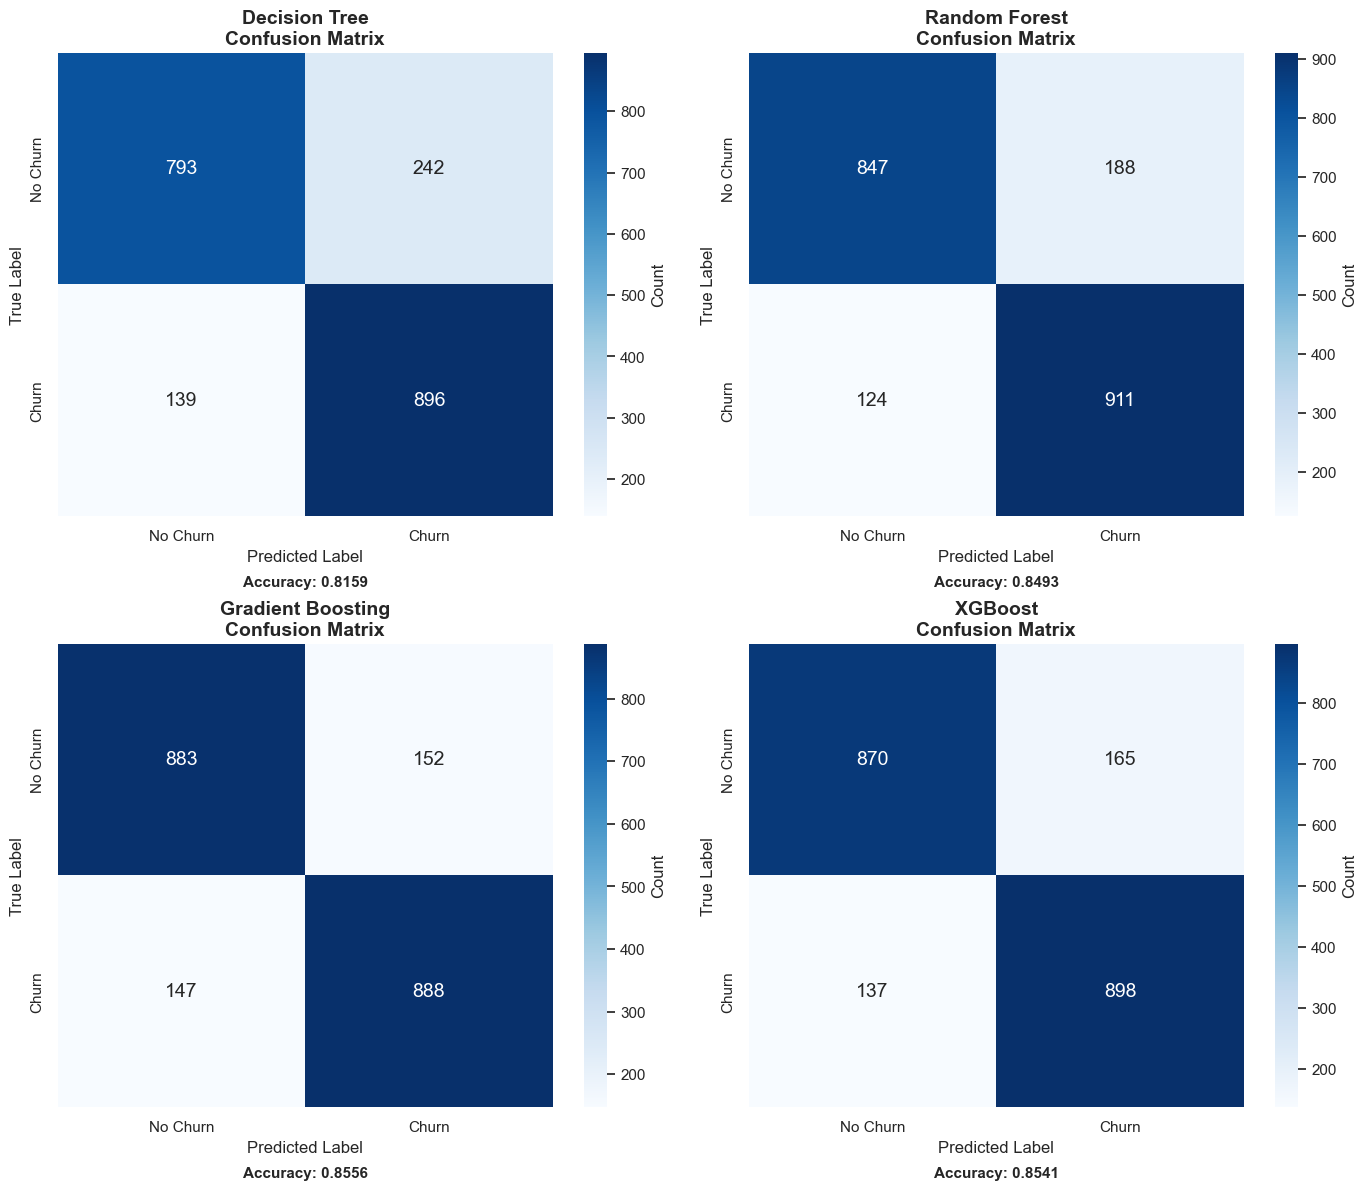

In [32]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

models = [
    ('Decision Tree', y_pred_dt),
    ('Random Forest', y_pred_rf),
    ('Gradient Boosting', y_pred_gb),
    ('XGBoost', y_pred_xgb)
]

for idx, (model_name, y_pred) in enumerate(models):
    row = idx // 2
    col = idx % 2
    
    cm = confusion_matrix(y_test, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[row, col],
                cbar_kws={'label': 'Count'}, annot_kws={'size': 14})
    
    axes[row, col].set_title(f'{model_name}\nConfusion Matrix', 
                             fontsize=14, fontweight='bold')
    axes[row, col].set_xlabel('Predicted Label', fontsize=12)
    axes[row, col].set_ylabel('True Label', fontsize=12)
    axes[row, col].set_xticklabels(['No Churn', 'Churn'])
    axes[row, col].set_yticklabels(['No Churn', 'Churn'])
    
    # Add accuracy text
    acc = accuracy_score(y_test, y_pred)
    axes[row, col].text(0.5, -0.15, f'Accuracy: {acc:.4f}', 
                        transform=axes[row, col].transAxes,
                        ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

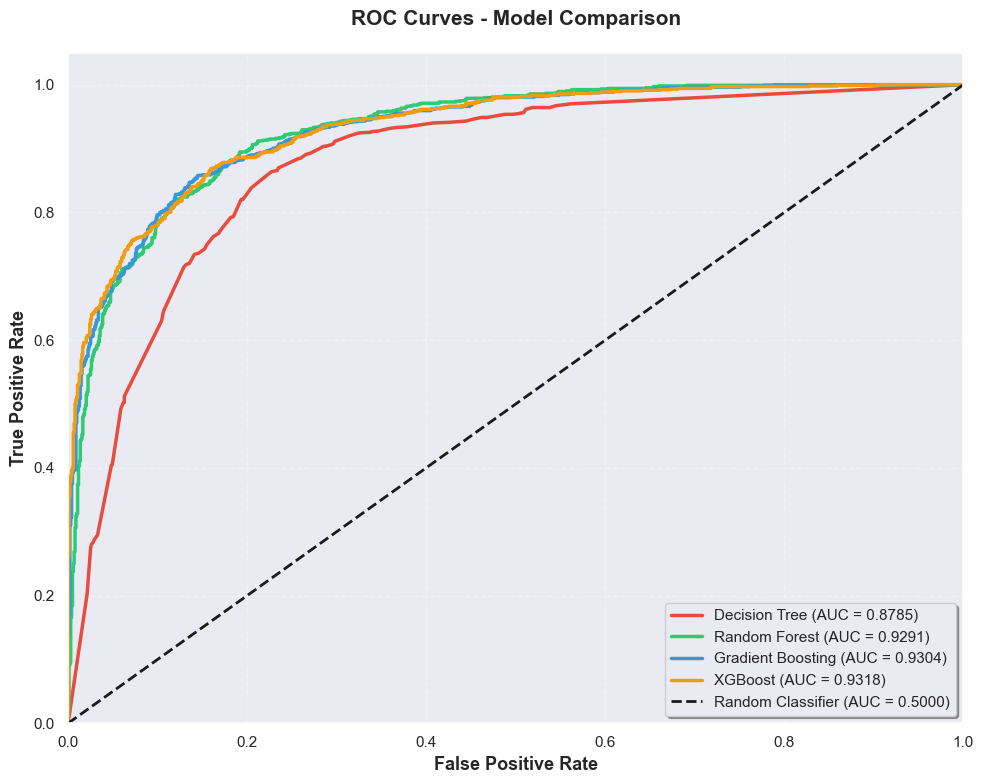

In [33]:
from sklearn.metrics import roc_curve

fig, ax = plt.subplots(figsize=(10, 8))

models_roc = [
    ('Decision Tree', y_pred_proba_dt, '#e74c3c'),
    ('Random Forest', y_pred_proba_rf, '#2ecc71'),
    ('Gradient Boosting', y_pred_proba_gb, '#3498db'),
    ('XGBoost', y_pred_proba_xgb, '#f39c12')
]

for model_name, y_pred_proba, color in models_roc:
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    ax.plot(fpr, tpr, linewidth=2.5, label=f'{model_name} (AUC = {auc:.4f})', 
            color=color)

# Plot diagonal line
ax.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier (AUC = 0.5000)')

ax.set_xlabel('False Positive Rate', fontsize=13, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=13, fontweight='bold')
ax.set_title('ROC Curves - Model Comparison', fontsize=15, fontweight='bold', pad=20)
ax.legend(loc='lower right', fontsize=11, frameon=True, shadow=True)
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])

plt.tight_layout()
plt.show()

## Saving the Best Model

In [34]:
import pickle
import os

# Create models directory if it doesn't exist
os.makedirs('models', exist_ok=True)

# Save the best XGBoost model
with open('models/xgboost_model.pkl', 'wb') as f:
    pickle.dump(best_xgb, f)
print("✓ XGBoost model saved to 'models/xgboost_model.pkl'")

# Save the StandardScaler
with open('models/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("✓ StandardScaler saved to 'models/scaler.pkl'")

# Save the label encoders
with open('models/label_encoders.pkl', 'wb') as f:
    pickle.dump(label_encoders, f)
print("✓ Label encoders saved to 'models/label_encoders.pkl'")

# Save feature names for reference
feature_names = X_train.columns.tolist()
with open('models/feature_names.pkl', 'wb') as f:
    pickle.dump(feature_names, f)
print("✓ Feature names saved to 'models/feature_names.pkl'")

# Save model metadata
model_metadata = {
    'model_name': 'XGBoost',
    'best_params': study_xgb.best_params,
    'f1_score': study_xgb.best_value,
    'accuracy': accuracy_score(y_test, y_pred_xgb),
    'precision': precision_score(y_test, y_pred_xgb),
    'recall': recall_score(y_test, y_pred_xgb),
    'roc_auc': roc_auc_score(y_test, y_pred_proba_xgb),
    'training_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'n_features': len(feature_names),
    'feature_names': feature_names
}

with open('models/model_metadata.pkl', 'wb') as f:
    pickle.dump(model_metadata, f)
print("✓ Model metadata saved to 'models/model_metadata.pkl'")

print("\n" + "="*70)
print("ALL MODEL ARTIFACTS SAVED SUCCESSFULLY!")
print("="*70)
print(f"\nModel Performance Summary:")
print(f"  - F1-Score: {model_metadata['f1_score']:.4f}")
print(f"  - Accuracy: {model_metadata['accuracy']:.4f}")
print(f"  - ROC-AUC: {model_metadata['roc_auc']:.4f}")
print(f"  - Number of Features: {model_metadata['n_features']}")
print(f"  - Saved at: {model_metadata['training_date']}")


✓ XGBoost model saved to 'models/xgboost_model.pkl'
✓ StandardScaler saved to 'models/scaler.pkl'
✓ Label encoders saved to 'models/label_encoders.pkl'
✓ Feature names saved to 'models/feature_names.pkl'
✓ Model metadata saved to 'models/model_metadata.pkl'

ALL MODEL ARTIFACTS SAVED SUCCESSFULLY!

Model Performance Summary:
  - F1-Score: 0.8561
  - Accuracy: 0.8541
  - ROC-AUC: 0.9318
  - Number of Features: 30
  - Saved at: 2025-10-06 14:45:58
